# Лабораторна робота №6
**Тема:** Навчання з підкріпленням (Reinforcement Learning)

## Мета роботи
Ознайомитися з основними принципами навчання з підкріпленням.

Розібрати поняття агента, середовища, винагороди та політики.

Реалізувати простий приклад алгоритму Q-learning для задачі прийняття рішень.

Навчитися аналізувати результати роботи алгоритму.

Навчання з підкріпленням (RL) — це підхід у машинному навчанні, де агент взаємодіє із середовищем, отримує винагороди та навчається приймати оптимальні рішення.

**Основні поняття:**

Агент — система, яка приймає рішення.

Середовище — світ, у якому діє агент.

Стан (state) — опис ситуації в середовищі.

Дія (action) — вибір агента.

Винагорода (reward) — числовий сигнал, що показує корисність дії.

Політика (policy) — стратегія вибору дій.

Функція цінності (value function) — оцінка довгострокової вигоди від стану.

Алгоритм Q-learning:
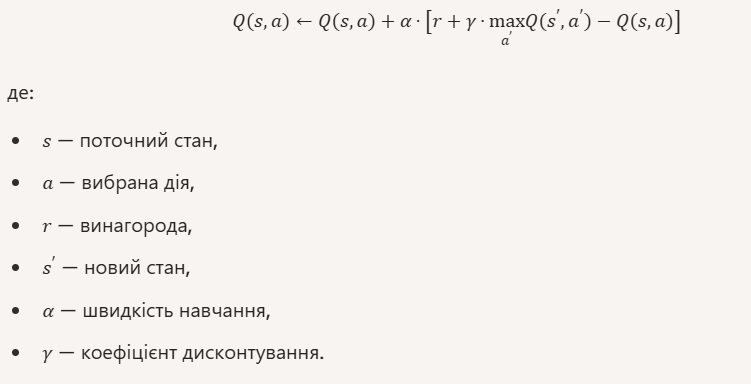

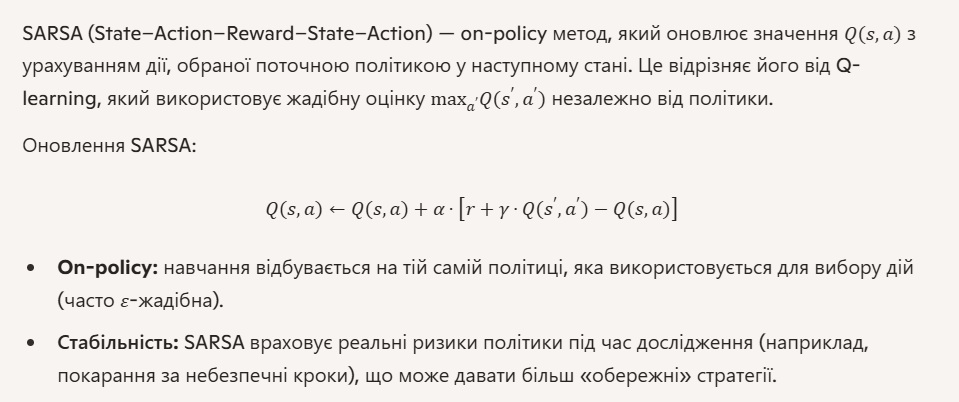




**Завдання** реалізувати алгоритми SARSA та Q-learning для задачі пошуку шляху в дискретному лабіринті.

Результат: отримати політики, порівняти збіжність, стабільність та якість маршрутів.

**Опис задачі пошуку шляху в лабіринті**
Середовище: ґратка 6×6 з перешкодами (стіни), стартом і ціллю.

Стан: позиція агента на полі.

Дії: рух у чотирьох напрямках (вгору/вниз/ліво/право).

Винагорода:

+10 за досягнення цілі,

−1 за кожен крок,

−5 за удар у стіну (агент лишається на місці),

0 інакше.

Припинення епізоду: досягнення цілі або ліміт кроків (наприклад, 100).

Порада: штраф за крок стимулює короткі маршрути, штраф за стіну — обережність.

**Пояснення**

Допоміжні функції

1. to_state(pos)

Перетворює координати (рядок, стовпець) у номер стану (одне число). Наприклад, для поля 6×6 позиція (2,3) → стан 2*6+3 = 15. Це зручно, бо Q-таблиця індексується номерами станів, а не координатами.

2. in_bounds(r, c)

Перевіряє, чи координати знаходяться в межах лабіринту. Якщо агент виходить за межі, ми вважаємо це ударом у стіну.

3. step(pos, action_idx)

Реалізує перехід агента:обчислює нову позицію після дії, перевіряє стіни та межі, повертає новий стан, винагороду та ознаку завершення епізоду.Це фактично «модель середовища».

4. choose_action(Q, state, epsilon)

Вибирає дію за ε-жадібною політикою:з імовірністю ε — випадкова дія (дослідження), інакше — найкраща дія за Q-таблицею (експлуатація). Це ключ до балансу «дослідження ↔ експлуатація».


In [ ]:
import numpy as np
import random

# Параметри
alpha = 0.1         # швидкість навчання
gamma = 0.95        # дисконтування
epsilon = 0.2       # ε-жадібна політика
episodes = 2000     # епізоди
max_steps = 100     # ліміт кроків на епізод

# Лабіринт 6x6: 0 — вільно, 1 — стіна
maze = np.array([
    [0,0,0,0,1,0],
    [1,1,0,0,1,0],
    [0,0,0,1,0,0],
    [0,1,0,0,0,1],
    [0,0,1,0,0,0],
    [0,0,0,0,1,0]
])

start = (0, 0)
goal  = (5, 5)

actions = [( -1,0), (1,0), (0,-1), (0,1)]  # ↑ ↓ ← →
A_UP, A_DOWN, A_LEFT, A_RIGHT = range(4)

# Допоміжні функції
def to_state(pos): return pos[0]*maze.shape[1] + pos[1]
def in_bounds(r, c): return 0 <= r < maze.shape[0] and 0 <= c < maze.shape[1]

state_count = maze.size
Q_sarsa = np.zeros((state_count, 4))

def step(pos, action_idx):
    dr, dc = actions[action_idx]
    nr, nc = pos[0] + dr, pos[1] + dc
    # Перевірка меж та стін
    if not in_bounds(nr, nc) or maze[nr, nc] == 1:
        reward = -5
        new_pos = pos  # удар у стіну: лишаємось
        done = False
    else:
        new_pos = (nr, nc)
        reward = -1
        done = (new_pos == goal)
        if done: reward = 10
    return new_pos, reward, done

def choose_action(Q, state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 3)
    return int(np.argmax(Q[state]))

# Навчання SARSA
for ep in range(episodes):
    pos = start
    s = to_state(pos)
    a = choose_action(Q_sarsa, s, epsilon)
    for _ in range(max_steps):
        new_pos, r, done = step(pos, a)
        s_next = to_state(new_pos)
        a_next = choose_action(Q_sarsa, s_next, epsilon)
        # Якщо епізод завершився, наступна дія не впливає
        td_target = r + (0 if done else gamma * Q_sarsa[s_next, a_next])
        td_error = td_target - Q_sarsa[s, a]
        Q_sarsa[s, a] += alpha * td_error
        pos, s, a = new_pos, s_next, a_next
        if done: break

# Відновлення політики (напрямки дій у ґратці)
policy_sarsa = np.array([np.argmax(Q_sarsa[s]) for s in range(state_count)]).reshape(maze.shape)
print("Політика SARSA (0↑ 1↓ 2← 3→):")
print(policy_sarsa)


**Інтерпретація результату**
Кожне число відповідає дії:

0 → рух вгору ↑

1 → рух вниз ↓

2 → рух вліво ←

3 → рух вправо →

Відповідність лабіринту:

Матриця має ту ж форму, що й maze (6×6).

У клітинках, де стоїть 1 (стіна), політика теж показує якусь дію, але вона не має сенсу, бо агент туди не може потрапити.

У клітинках зі значенням 0 (вільні) політика показує напрямок, куди агент буде рухатися.

Як зрозуміти шлях:

Починаєш зі старту (0,0).

Дивишся у політику: наприклад, там стоїть 3 → рух вправо.

Переходиш у нову клітинку і знову дивишся політику.

Повторюєш, доки не дійдеш до цілі (5,5).

Що означає результат:

Якщо політика сформувала послідовний маршрут до цілі, значить алгоритм навчився.

Якщо бачиш «дивні» цикли (наприклад, агент ходить туди-сюди), це може бути через:

занадто велике epsilon (багато випадкових дій),

недостатня кількість епізодів,

занадто малі/великі винагороди.

**Крок 2** Реалізація для алгоритму Q-learning

In [ ]:
import numpy as np
import random

# Параметри
alpha = 0.1         # швидкість навчання
gamma = 0.95        # коефіцієнт дисконтування
epsilon = 0.2       # ε-жадібна політика
episodes = 2000     # кількість епізодів
max_steps = 100     # ліміт кроків на епізод

# Лабіринт 6x6: 0 — вільно, 1 — стіна
maze = np.array([
    [0,0,0,0,1,0],
    [1,1,0,0,1,0],
    [0,0,0,1,0,0],
    [0,1,0,0,0,1],
    [0,0,1,0,0,0],
    [0,0,0,0,1,0]
])

start = (0, 0)
goal  = (5, 5)

actions = [(-1,0), (1,0), (0,-1), (0,1)]  # ↑ ↓ ← →
A_UP, A_DOWN, A_LEFT, A_RIGHT = range(4)

# Допоміжні функції
def to_state(pos): return pos[0]*maze.shape[1] + pos[1]
def in_bounds(r, c): return 0 <= r < maze.shape[0] and 0 <= c < maze.shape[1]

state_count = maze.size
Q_ql = np.zeros((state_count, 4))

def step(pos, action_idx):
    dr, dc = actions[action_idx]
    nr, nc = pos[0] + dr, pos[1] + dc
    if not in_bounds(nr, nc) or maze[nr, nc] == 1:
        reward = -5
        new_pos = pos
        done = False
    else:
        new_pos = (nr, nc)
        reward = -1
        done = (new_pos == goal)
        if done: reward = 10
    return new_pos, reward, done

def choose_action(Q, state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 3)
    return int(np.argmax(Q[state]))

# Навчання Q-learning
for ep in range(episodes):
    pos = start
    s = to_state(pos)
    for _ in range(max_steps):
        a = choose_action(Q_ql, s, epsilon)
        new_pos, r, done = step(pos, a)
        s_next = to_state(new_pos)
        # Оновлення Q-learning: жадібне значення наступного стану
        td_target = r + (0 if done else gamma * np.max(Q_ql[s_next]))
        td_error = td_target - Q_ql[s, a]
        Q_ql[s, a] += alpha * td_error
        pos, s = new_pos, s_next
        if done: break

# Відновлення політики
policy_ql = np.array([np.argmax(Q_ql[s]) for s in range(state_count)]).reshape(maze.shape)
print("Політика Q-learning (0↑ 1↓ 2← 3→):")
print(policy_ql)


**Крок 3. Аналіз результатів**

Виконаємо симуляцію проходження лабиринту

In [ ]:
def simulate(policy, start, goal, maze, max_steps=50):
    pos = start
    path = [pos]
    for _ in range(max_steps):
        s = to_state(pos)
        a = policy[pos[0], pos[1]]
        pos, _, done = step(pos, a)
        path.append(pos)
        if done:
            break
    return path

# Симуляція для SARSA
path_sarsa = simulate(policy_sarsa, start, goal, maze)
print("Шлях SARSA:", path_sarsa)

# Симуляція для Q-learning
path_ql = simulate(policy_ql, start, goal, maze)
print("Шлях Q-learning:", path_ql)

Порівнюючи ці списки, ти побачиш:

SARSA може робити більше кроків і обходити стіни «з запасом».

Q-learning прагне до найкоротшого маршруту, навіть якщо він проходить близько до стін.

**Завдання для самостійного виконання**

Кількість кроків і винагорода

Порахуй довжину шляху (len(path)).

Порівняй середню винагороду за епізод.

SARSA часто дає меншу середню винагороду, але стабільнішу.

Q-learning може швидше досягати цілі з більшою винагородою, але іноді «застрягає» або ризикує.

Якщо різниця непомітна, спробуй виконати навчання для більш складного лабиринту

maze = np.array([
    [0,0,0,0,0,0,0,0],
    [0,1,1,1,0,1,1,0],
    [0,0,0,1,0,0,1,0],
    [1,0,1,1,1,0,1,0],
    [0,0,0,0,0,0,1,0],
    [0,1,1,1,1,0,1,0],
    [0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,0]
])
start = (0,0)
goal  = (7,7)

**Особливість:** є вузькі проходи, де агент може «ризикувати» йти коротким шляхом біля стін, або робити довший обхід.

Очікуваний результат:

SARSA буде частіше вибирати обхідні маршрути, щоб уникати ризику.

Q-learning буде прагнути до найкоротшого шляху, навіть якщо він проходить через небезпечні вузькі місця.

In [ ]:
#Тут має бути Ваш код


Тут мають бути Ваші висновки